# <center>Predicting Football Match Outcome
### <center> **Prathamesh Tari**  
<center> INFO 7390, Fall 2017, Northeastern University, tari.p@husky.neu.edu

   European Football or soccer is the world’s most popular team sport. It is played by over 150 million men and women of all ages in more than 200 countries [1].It is also one of the favorite sports for betting. The current estimations, which include both the illegal markets and the legal markets, suggest the sports match-betting industry is worth anywhere between 700bn and 1tn dollars a year [2]. 
   
The bookies have their own prediction model and they get it right about 53% of the time [3].
Football pundit Mark Lawrenson had prediction accuracy of 52.6% [4]. 
The aim of this project is to build a system to predict the outcome using machine learning algorithms like Support Vector Machine, Naïve Bayes and logistic Regression.

### Dataset

I am using two datasets for this project. The first dataset I got the data science community Kaggle https://www.kaggle.com/hugomathien/soccer. This dataset is used to perform exploratory data analysis. But this dataset has few missing data essential for prediction so the second dataset I am using is from http://football-data.co.uk/data.php. This dataset had more seasons and I am compiling these seasons into one and creating features to make prediction

Initially I am performing Exploratory Data Analysis on the dataset I got from the Kaggle website.

This dataset was in sqlite format and has tables of Country, League, Match, Player, Player Attributes, Team ,Team Attributes and sequences. It has information of more than 25000 matches, 10000 players, 11 European Countries with their lead championship from 2008 to 2016, Players and Teams attributes sourced from EA Sports' FIFA video game series, betting odds from up to 10 providers


I am only going to use the information from country, match, league and team for the EDA. This are the information which would be useful to understand the game.

In [234]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.gridspec as gridspec
from numpy import random
import scipy.stats as scipy

from IPython.display import display

from sklearn.metrics import accuracy_score

with sqlite3.connect('database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    tempmatch = pd.read_sql_query("SELECT * from Match", con)
    matches3 = matches2 = matches

In [235]:
matches.tail()
#matches.describe()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [237]:
leagues

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [238]:
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...,...
294,49479,10190,898.0,FC St. Gallen,GAL
295,49837,10191,1715.0,FC Thun,THU
296,50201,9777,324.0,Servette FC,SER
297,50204,7730,1862.0,FC Lausanne-Sports,LAU


### Selecting the countries of interest

First we will to select the countries of interest for our analysis. I am selecting England, Germany and Spain as these are the most popular and most watched leagues in football. These leagues are the most competitive league and it would give better understanding of the game.

In [241]:
main_countries = ['England','Germany','Spain']
countries = countries[countries.name.isin(main_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,7809,Germany,7809,Germany 1. Bundesliga
2,21518,Spain,21518,Spain LIGA BBVA


### Merge the leagues with corresponding matches


In [243]:
req_matches = matches[matches.league_id.isin(leagues['id'])]
req_matches = req_matches[['id','league_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches.dropna(inplace=True)
req_matches.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals
1728,1729,1729,10260,10261,1,1,2008/2009,2
1729,1730,1729,9825,8659,1,0,2008/2009,1
1730,1731,1729,8472,8650,0,1,2008/2009,1
1731,1732,1729,8654,8528,2,1,2008/2009,3
1732,1733,1729,10252,8456,4,2,2008/2009,6


### Adding results of the match

As these dataset did not contain the result of the match we would add the results by comparing the home team goal and away team goal for that match. If the home team has more goals than the away team then the home team won the match and if not then the away team won the match. If both the goals are equal matche ended in draw. I am giving win as 1, draw as 0 and loss as -1 and then appended it to the table.

In [246]:
def res(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    else:
        val = -1
    return val

req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.head()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
1728,1729,1729,10260,10261,1,1,2008/2009,2,0
1729,1730,1729,9825,8659,1,0,2008/2009,1,1
1730,1731,1729,8472,8650,0,1,2008/2009,1,-1
1731,1732,1729,8654,8528,2,1,2008/2009,3,1
1732,1733,1729,10252,8456,4,2,2008/2009,6,1


### Separating the leagues


The matches need to be separated and grouped by their leagues. A new dataframe for storing the separated leagues is created.

In [249]:
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_x','id_y','country_id'],axis = 1)
english = new_matches[new_matches.name == "England"]
spanish = new_matches[new_matches.name == "Spain"]
german = new_matches[new_matches.name == "Germany"]

display(english.head())
display(german.head())
display(spanish.tail())

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League
1,1729,9825,8659,1,0,2008/2009,1,1,England,England Premier League
2,1729,8472,8650,0,1,2008/2009,1,-1,England,England Premier League
3,1729,8654,8528,2,1,2008/2009,3,1,England,England Premier League
4,1729,10252,8456,4,2,2008/2009,6,1,England,England Premier League


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
3040,7809,9823,9790,2,2,2008/2009,4,0,Germany,Germany 1. Bundesliga
3041,7809,8178,9789,2,3,2008/2009,5,-1,Germany,Germany 1. Bundesliga
3042,7809,10189,9904,3,0,2008/2009,3,1,Germany,Germany 1. Bundesliga
3043,7809,8721,8722,2,1,2008/2009,3,1,Germany,Germany 1. Bundesliga
3044,7809,9810,8177,0,2,2008/2009,2,-1,Germany,Germany 1. Bundesliga


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
8523,21518,9906,10267,2,1,2015/2016,3,1,Spain,Spain LIGA BBVA
8524,21518,9864,9783,2,0,2015/2016,2,1,Spain,Spain LIGA BBVA
8525,21518,8315,9869,3,0,2015/2016,3,1,Spain,Spain LIGA BBVA
8526,21518,7878,8603,1,1,2015/2016,2,0,Spain,Spain LIGA BBVA
8527,21518,8370,8558,3,0,2015/2016,3,1,Spain,Spain LIGA BBVA


### Grouping and dividing by seasons

Then dividing them by their seasons and storing them into new dataframe.

In [252]:
e = english.groupby('season')
s = spanish.groupby('season')
g = german.groupby('season')
seasons
display(e.head(2))
display(s.tail(2))
display(g.tail(2))

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League
1,1729,9825,8659,1,0,2008/2009,1,1,England,England Premier League
380,1729,10260,8658,1,0,2009/2010,1,1,England,England Premier League
381,1729,8586,8650,2,1,2009/2010,3,1,England,England Premier League
760,1729,10252,8654,3,0,2010/2011,3,1,England,England Premier League
761,1729,8655,8668,1,0,2010/2011,1,1,England,England Premier League
1140,1729,8655,8602,1,2,2011/2012,3,-1,England,England Premier League
1141,1729,9879,10252,0,0,2011/2012,0,0,England,England Premier League
1520,1729,9825,8472,0,0,2012/2013,0,0,England,England Premier League
1521,1729,8668,10260,1,0,2012/2013,1,1,England,England Premier League


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
5866,21518,9906,8661,2,0,2008/2009,2,1,Spain,Spain LIGA BBVA
5867,21518,10267,8696,2,4,2008/2009,6,-1,Spain,Spain LIGA BBVA
6246,21518,8394,9865,2,1,2009/2010,3,1,Spain,Spain LIGA BBVA
6247,21518,9864,10267,0,1,2009/2010,1,-1,Spain,Spain LIGA BBVA
6626,21518,9783,8558,3,0,2010/2011,3,1,Spain,Spain LIGA BBVA
6627,21518,8661,8581,2,1,2010/2011,3,1,Spain,Spain LIGA BBVA
7006,21518,8603,8370,0,2,2011/2012,2,-1,Spain,Spain LIGA BBVA
7007,21518,9869,7878,2,0,2011/2012,2,1,Spain,Spain LIGA BBVA
7386,21518,9910,9783,1,1,2012/2013,2,0,Spain,Spain LIGA BBVA
7387,21518,8370,8634,0,5,2012/2013,5,-1,Spain,Spain LIGA BBVA


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,name,name_y
3344,7809,9788,8295,1,0,2008/2009,1,1,Germany,Germany 1. Bundesliga
3345,7809,8226,9790,3,0,2008/2009,3,1,Germany,Germany 1. Bundesliga
3650,7809,8722,9905,1,0,2009/2010,1,1,Germany,Germany 1. Bundesliga
3651,7809,8165,8177,3,0,2009/2010,3,1,Germany,Germany 1. Bundesliga
3956,7809,9904,8722,2,1,2010/2011,3,1,Germany,Germany 1. Bundesliga
3957,7809,8165,8721,2,1,2010/2011,3,1,Germany,Germany 1. Bundesliga
4262,7809,8721,8165,2,1,2011/2012,3,1,Germany,Germany 1. Bundesliga
4263,7809,9788,8178,2,2,2011/2012,4,0,Germany,Germany 1. Bundesliga
4568,7809,8357,8697,1,1,2012/2013,2,0,Germany,Germany 1. Bundesliga
4569,7809,8194,8721,1,4,2012/2013,5,-1,Germany,Germany 1. Bundesliga


### Plotting total goals scored each season


We plot the total number of goals scored by all team in each season. We plot this on pyplot.

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

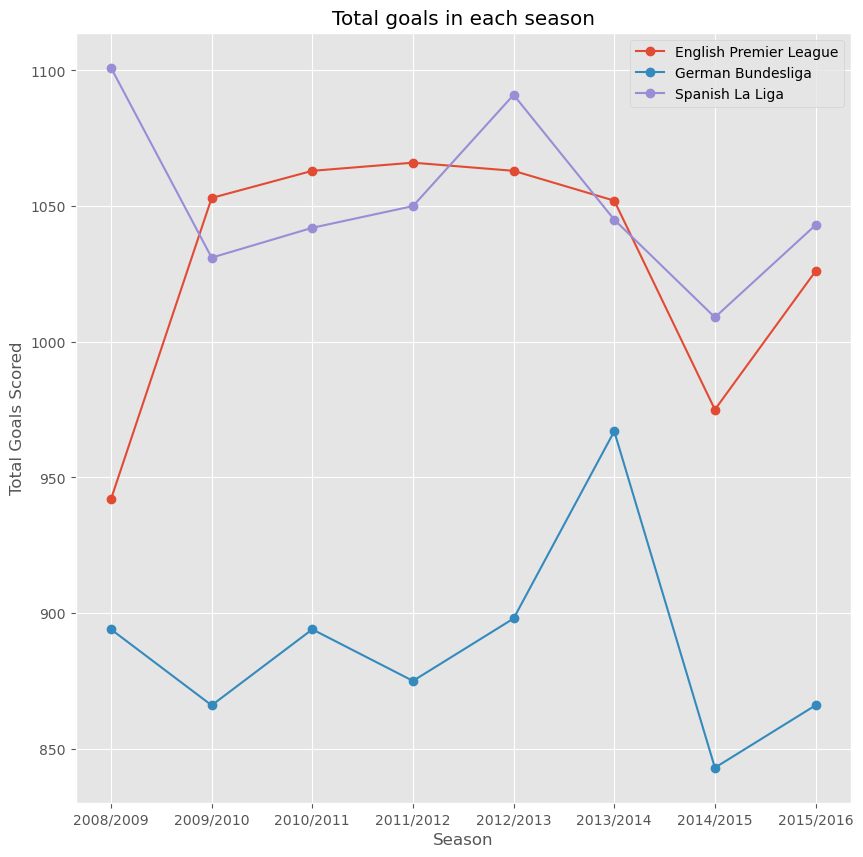

In [255]:
fig = plt.figure(figsize=(10, 10))
plt.title("Total goals in each season")
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.ylabel("Total Goals Scored")
num_seasons = range(len(seasons))

plt.plot(num_seasons,e.total_goals.sum().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,g.total_goals.sum().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,s.total_goals.sum().values,label = "Spanish La Liga", marker = 'o')
plt.legend()
seasons

  We can see that the Spanish teams overall score more than the teams in Premier League and in Bundesliga. 
  But the total goals in Bundesliga is low due to the fact that only 18 teams compete in the league. So each team in Bundesliga plays only 34 matches in a season whereas each team in premier league plays 38 matches. So the total games played in Premier League and La Liga is 380 whereas total games played in Bundesliga is 306.

### We calculate average goals scored in each game

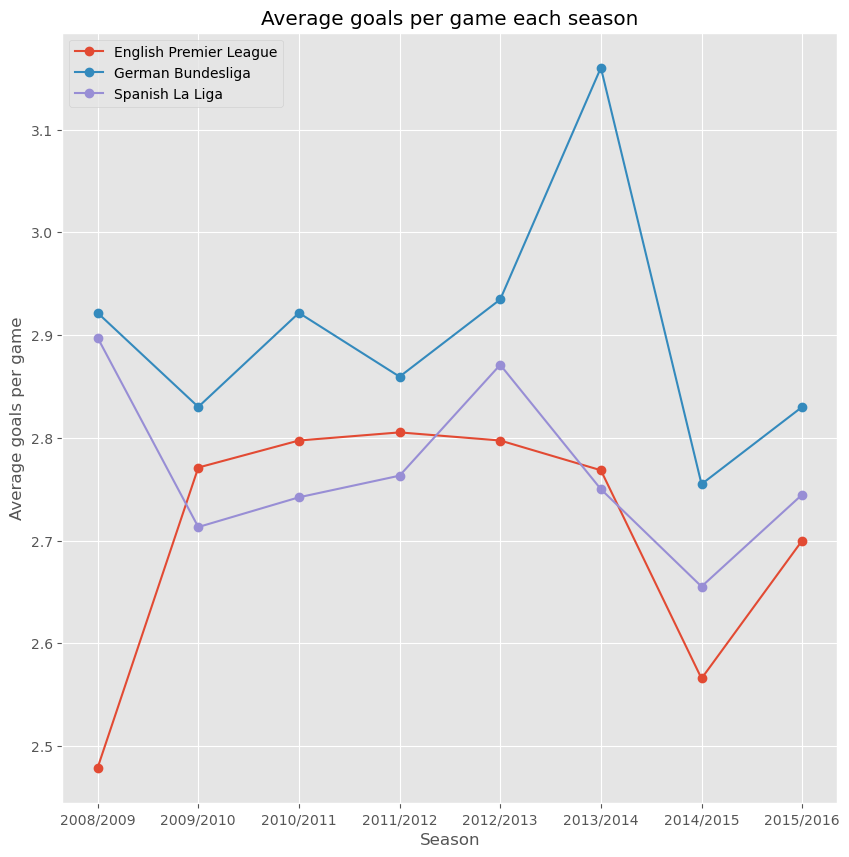

In [269]:
#Plotting average goals scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlabel("Season")
plt.title("Average goals per game each season")
plt.ylabel("Average goals per game")

plt.plot(num_seasons,e.total_goals.mean().values,label = "English Premier League", marker = 'o')
plt.plot(num_seasons,g.total_goals.mean().values,label = "German Bundesliga", marker = 'o')
plt.plot(num_seasons,s.total_goals.mean().values,label = "Spanish La Liga", marker = 'o')
plt.legend(loc = 2)


The Bundesliga teams score way more on average in each game that the teams in other leagues. In the 2013/2014 season, Bundesliga teams scored more than 3 goals each game on an average (967 goals in 306 matches - 3.16 per match). 

In [272]:
average_goals_english = english.total_goals.mean()
average_goals_spanish = spanish.total_goals.mean()
average_goals_german = german.total_goals.mean()
#print("{:.2}".format(average_goals_english))
#print("{:.2}".format(average_goals_spanish))
#print("{:.2}".format(average_goals_german))

 Average goals in the English Premier League is 2.7

 Average goals in the Spanish La Liga is 2.8

 Average goals in the Germany BundesLiga is 2.9

# Top Goal Scoring Team at Home

To see which team scores the most goal when playing on home turf.

In [277]:
#Merging Home team and matches

matches_h_teams = pd.merge(new_matches,teams,left_on='home_team_api_id', right_on='team_api_id')
matches_h_teams = matches_h_teams.drop(['id','team_api_id','team_fifa_api_id'],axis = 1)
matches_h_teams = matches_h_teams.rename(columns={'team_long_name':'home_team_long_name','name_y':'league_name','name':'country_name'})
matches_h_teams.head()

,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,country_name,league_name,home_team_long_name,team_short_name
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League,Manchester United,MUN
1,1729,9825,8659,1,0,2008/2009,1,1,England,England Premier League,Arsenal,ARS
2,1729,8472,8650,0,1,2008/2009,1,-1,England,England Premier League,Sunderland,SUN
3,1729,8654,8528,2,1,2008/2009,3,1,England,England Premier League,West Ham United,WHU
4,1729,10252,8456,4,2,2008/2009,6,1,England,England Premier League,Aston Villa,AVL


Text(0.5, 0, 'Team name')

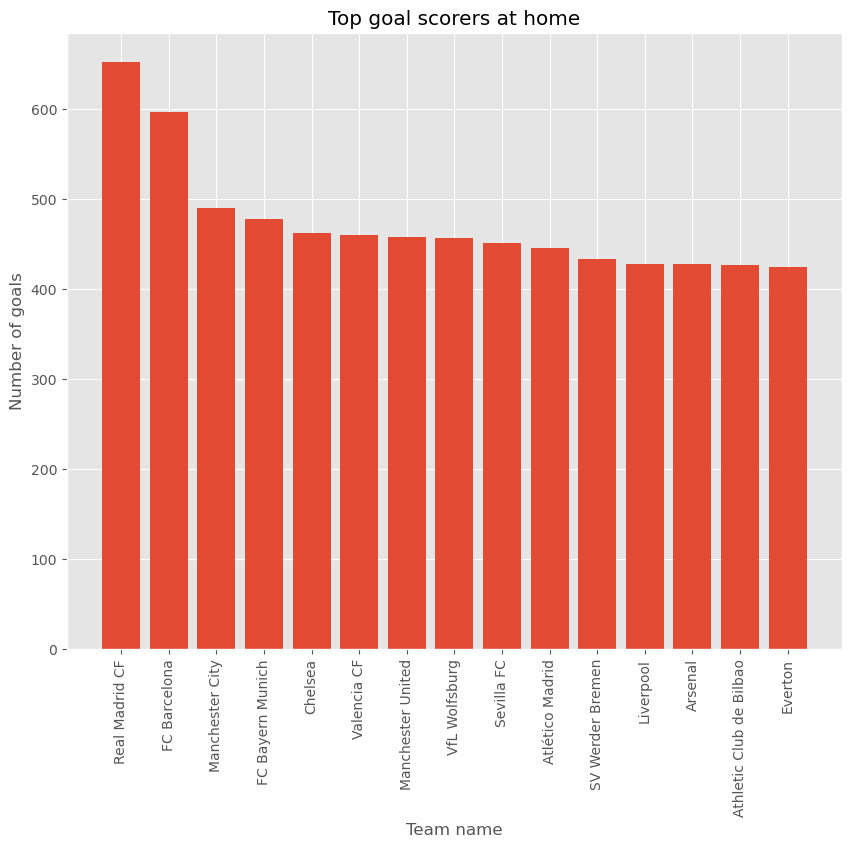

In [279]:
top_goal_scorers_home = matches_h_teams.groupby('home_team_long_name').total_goals.sum().sort_values(ascending = False)
top_goal_scorers_home.head(15)
%matplotlib inline 
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(15), top_goal_scorers_home.head(15).values,align = "center")
ax.set_xticks(range(15))
ax.set_xticklabels(top_goal_scorers_home.head(15).index,rotation = "vertical")
ax.set_title("Top goal scorers at home")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")

# Top Goal Scoring Team at away


To see which team scores the most in away matches.

In [283]:
#Merging Away team and matches

matches_a_teams = pd.merge(new_matches,teams,left_on='away_team_api_id', right_on='team_api_id')
matches_a_teams = matches_a_teams.drop(['id','team_api_id','team_fifa_api_id'],axis = 1)
matches_a_teams = matches_a_teams.rename(columns={'team_long_name':'away_team_long_name','name_y':'league_name','name':'country_name'})
matches_a_teams.head()


,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result,country_name,league_name,away_team_long_name,team_short_name
0,1729,10260,10261,1,1,2008/2009,2,0,England,England Premier League,Newcastle United,NEW
1,1729,9825,8659,1,0,2008/2009,1,1,England,England Premier League,West Bromwich Albion,WBA
2,1729,8472,8650,0,1,2008/2009,1,-1,England,England Premier League,Liverpool,LIV
3,1729,8654,8528,2,1,2008/2009,3,1,England,England Premier League,Wigan Athletic,WIG
4,1729,10252,8456,4,2,2008/2009,6,1,England,England Premier League,Manchester City,MCI


Text(0.5, 0, 'Team name')

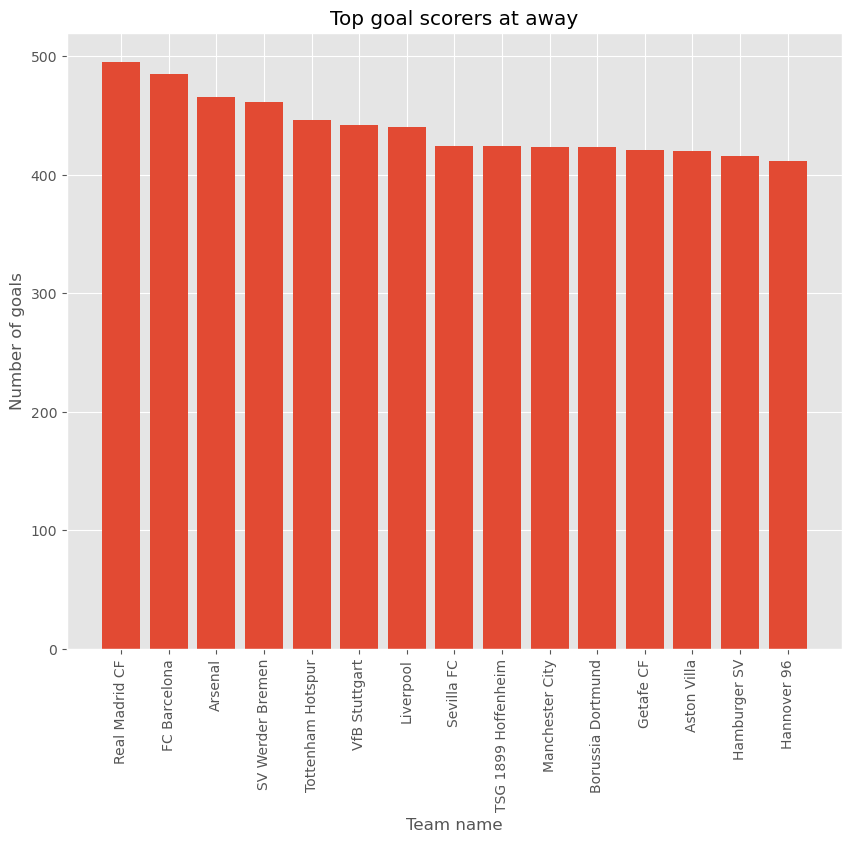

In [285]:
top_goal_scorers_away = matches_a_teams.groupby('away_team_long_name').total_goals.sum().sort_values(ascending = False)
top_goal_scorers_away.head(15)
%matplotlib inline 
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(15), top_goal_scorers_away.head(15).values,align = "center")
ax.set_xticks(range(15))
ax.set_xticklabels(top_goal_scorers_away.head(15).index,rotation = "vertical")
ax.set_title("Top goal scorers at away")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")

In [286]:
#select fields
matches = matches3[matches3.league_id.isin(leagues.id)]
matches = matches[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches.dropna(inplace=True)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365H,B365D,B365A
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1.29,5.5,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1.20,6.5,15.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,5.50,3.6,1.67
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,1.91,3.4,4.20
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,1.91,3.4,4.33


   #                      Probability of winning from Betting odds
!["Betting Odds"](files/odds.png "Betting odds probability")

#### Calculating entropy to determine predictability

Entropy is calculated to measure the disorder using bet365 odds. The higher the entropy value the more unpredictable are the resuts of the matches.

In [292]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

#compute match entropy
matches['entropy'] = matches.apply(match_entropy,axis=1)

In [293]:
#compute mean entropy for every league in every season
entropy_means = matches.groupby(['season','league_id']).entropy.mean()
entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')
entropy_means.columns = [leagues[leagues.id==x].name.values[0] for x in entropy_means.columns]
entropy_means.head(10)

,England,Germany,Spain
season,,,
2008/2009,0.984556,1.004276,1.010859
2009/2010,0.956496,0.997925,0.977810
2010/2011,0.983258,1.016264,0.975032
2011/2012,0.969593,1.001298,0.955339
2012/2013,0.981472,0.993993,0.970580
2013/2014,0.960473,0.977500,0.944218
2014/2015,0.980301,0.985835,0.933637
2015/2016,0.997819,0.974657,0.946813


Plotting entropy of the leagues for visual representation

Text(7.3, 0.952, 'more predictable')

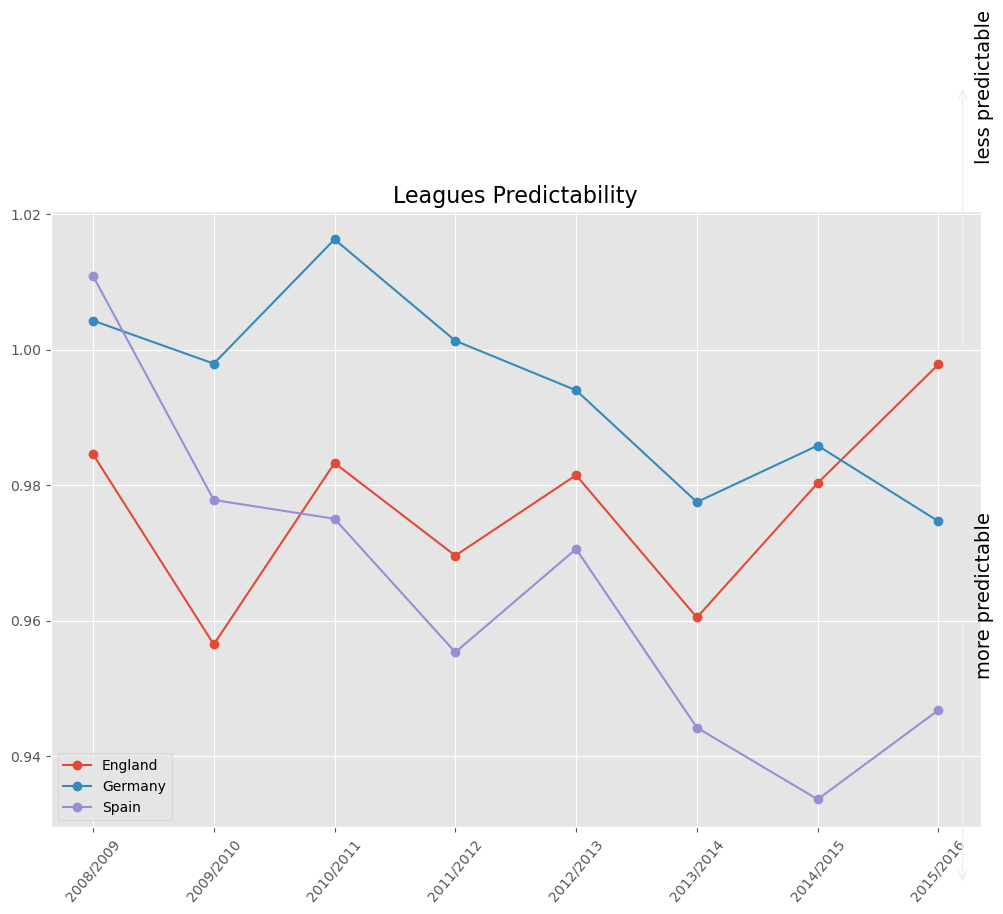

In [295]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues.id,colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')

#plt.savefig('figures/leagues_pred.png', bbox_inches='tight',dpi=600)

Since 2008 Bayern Munich and Barcelona have won Bundesliga and La Liga 6 times each. 

The top three teams in La Liga are same since 2012. The competition for title race is always between Barcelona, Real Madrid and Athletico Madrid, where Real Madrid won twice and Athletico won once since 2008.

From 2012-13 season Bayern Munich has won Bundesliga 5 times in a row. Borussia Dortmund also performs well and have won the league twice in 09-10 and 10-11 seasons.

Since 2008-09 in Premier League Manchester United have won the league thrice(08-09,10-11,12-13), Manchester City has won twice(11-12,13-14), Chelsea has won thrice(09-10,14-15,16-17) and Leceister City once(15-16). Leceister City was promoted to premier league in the previous season and it was placed 14th at the end of the season. Still it won the league the very next season, so we can see that it is very difficult to predict Premier League.


In [301]:
leagues


,id,name,country_id,name_y
0,1729,England,1729,England Premier League
1,7809,Germany,7809,Germany 1. Bundesliga
2,21518,Spain,21518,Spain LIGA BBVA


In [304]:
countries

,id,name
1,1729,England
3,7809,Germany
9,21518,Spain


The English Premier League is more unpredicatable than the rest of the leagues. So we will try to predict the matches for these leagues.

In [307]:
# Considering English Premier League

main_countries = ['England']
countries = countries[countries.name.isin(main_countries)]
countries = countries.rename(columns={'name': 'country_name'})
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,country_name,name,country_id,name_y
0,1729,England,England,1729,England Premier League


In [309]:
#Merge the leagues with corresponding matches

req_matches = matches2[matches2.league_id.isin(leagues['id'])]
req_matches = req_matches[['id','league_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.dropna(inplace=True)
req_matches.tail()

,id,league_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
4763,4764,1729,8466,8197,2,2,2015/2016,4,0
4764,4765,1729,10003,10194,0,1,2015/2016,1,-1
4765,4766,1729,8586,8650,0,0,2015/2016,0,0
4766,4767,1729,9817,9825,0,3,2015/2016,3,-1
4767,4768,1729,8659,8472,1,0,2015/2016,1,1


In [311]:
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_x','id_y','country_id'],axis = 1)
english = new_matches[new_matches.name == "England"]

# sum_goals = new_group_matches.home_team_goal.sum()
e = english.groupby('season')
seasons
%matplotlib inline


Home advantages always played important part in match outcome. But by what factor does home advantage affects the match.

### Getting total number of goals scored in Home matches

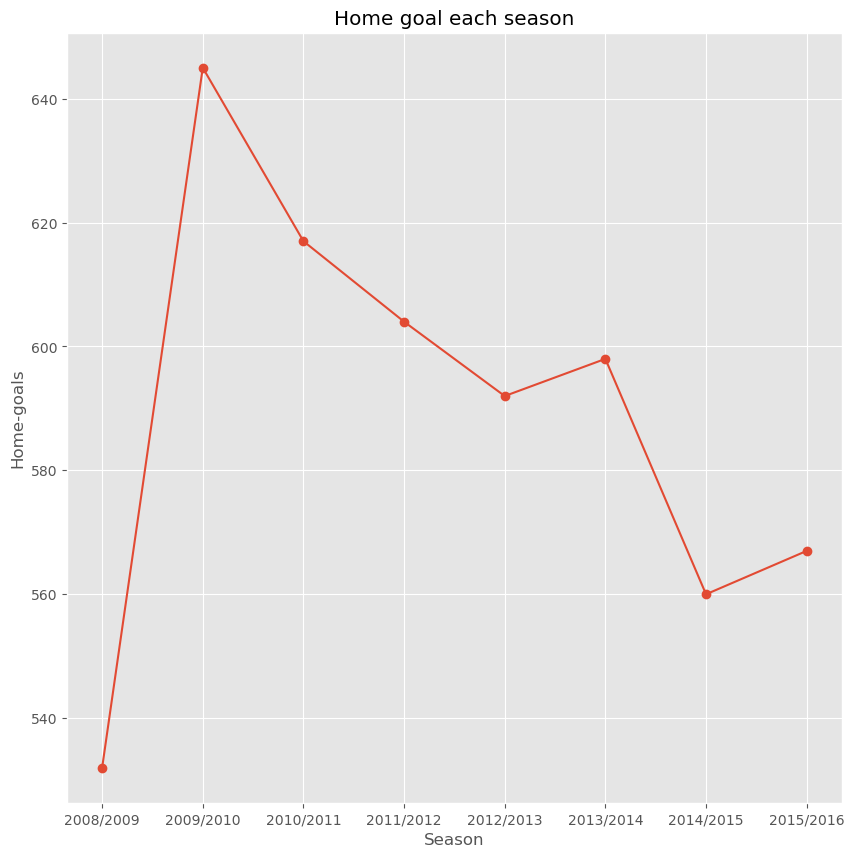

In [316]:
#Plotting home scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home goal each season')
plt.xlabel('Season')
plt.ylabel('Home-goals')
plt.plot(num_seasons,e.home_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Total number of goals scored in Away matches

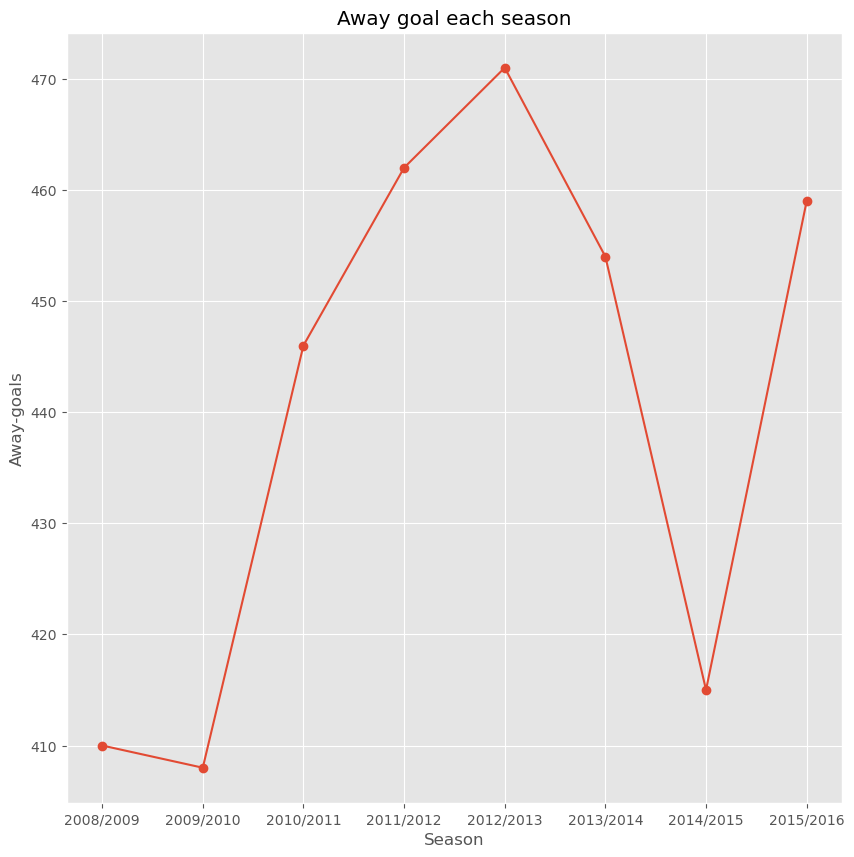

In [319]:
#Plotting away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Away goal each season')
plt.xlabel('Season')
plt.ylabel('Away-goals')
plt.plot(num_seasons,e.away_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Home goals to Away goals ratio

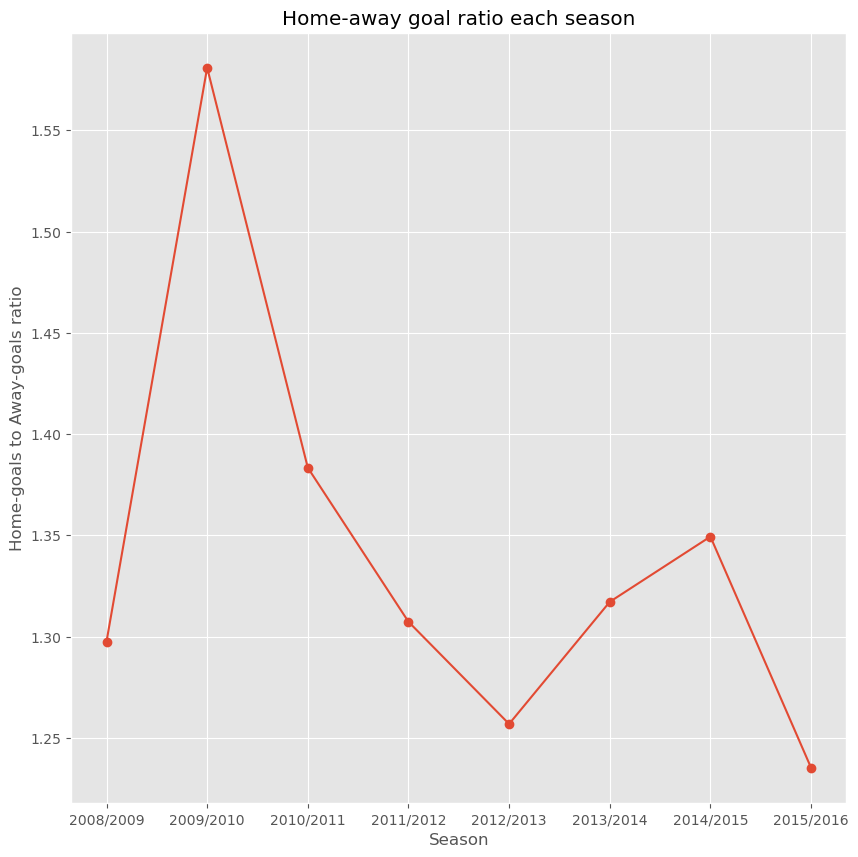

In [322]:
#Plotting home/away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home-away goal ratio each season')
plt.xlabel('Season')
plt.ylabel('Home-goals to Away-goals ratio')
plt.plot(num_seasons,e.home_team_goal.sum().values / e.away_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Home wins vs Home Loss

array([1.57272727, 2.12087912, 1.98888889, 1.47413793, 1.56603774,
       1.45528455, 1.49565217, 1.35344828])

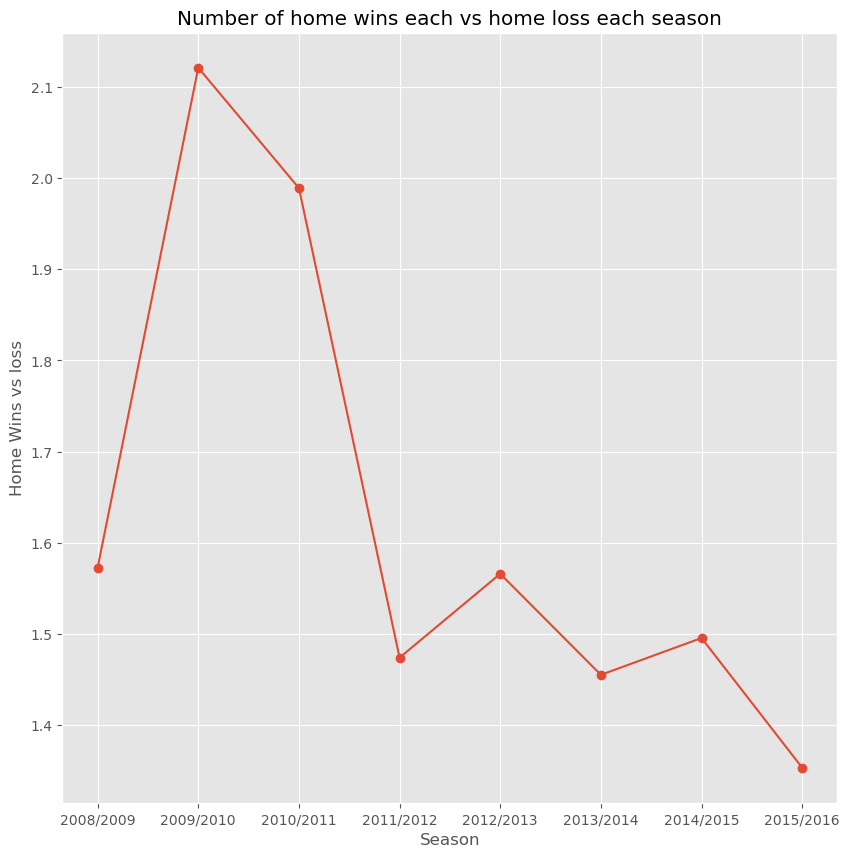

In [325]:
#Subsetting homewins vs homeloss from each of the leagues - ignoring draws.
e_hw = np.true_divide(english[english.result == 1].groupby('season').result.sum().values,english[english.result == -1].groupby('season').result.sum().values * -1)


#Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlim = (-20,20)
plt.ylim = (0,120)
plt.title("Number of home wins each vs home loss each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs loss")
plt.plot(num_seasons,e_hw,label = "English Premier League", marker = 'o')
display(e_hw)

We can clearly see that the home advantage in premier league is decreasing every season. Initially home matches were very good factor to determine the winner of the match. Now the matches have become very competitive and we cannot predict the match outcome just on the home advantage.

## Prediction 

We downloaded the data of English Premier League from 2000 from http://football-data.co.uk/data.php

This dataset contains information of all the game statistics like fulltime goals, halftime goals, corners, free kicks, fouls, yellow cards, red cards, total shots, shots on target etc.

In [331]:
# Read data from the CSV into a dataframe

loc = "/Users/hardikmehta/Desktop/project/notebook/Datasets/"

raw_data_1 = pd.read_csv(loc + '2000-01.csv')
raw_data_2 = pd.read_csv(loc + '2001-02.csv')
raw_data_3 = pd.read_csv(loc + '2002-03.csv')
raw_data_4 = pd.read_csv(loc + '2003-04.csv')
raw_data_5 = pd.read_csv(loc + '2004-05.csv')
raw_data_6 = pd.read_csv(loc + '2005-06.csv')
raw_data_7 = pd.read_csv(loc + '2006-07.csv')
raw_data_8 = pd.read_csv(loc + '2007-08.csv')
raw_data_9 = pd.read_csv(loc + '2008-09.csv')
raw_data_10 = pd.read_csv(loc + '2009-10.csv')
raw_data_11 = pd.read_csv(loc + '2010-11.csv')
raw_data_12 = pd.read_csv(loc + '2011-12.csv')
raw_data_13 = pd.read_csv(loc + '2012-13.csv')
raw_data_14 = pd.read_csv(loc + '2013-14.csv')
raw_data_15 = pd.read_csv(loc + '2014-15.csv')
raw_data_16 = pd.read_csv(loc + '2015-16.csv')

Selecting the required features and putting it in the dataframe

In [334]:
# Selecting the features

raw_data_1 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_2 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_3 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_4 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_5 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_6 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_7 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_8 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_9 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_10 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_11 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_12 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_13 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_14 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_15 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_16 =raw_data_1[['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]


In [336]:
# Concating the data on one dataframe

playing_stat = pd.concat([raw_data_1,raw_data_2,raw_data_3,raw_data_4,raw_data_5,raw_data_6,raw_data_7,raw_data_8,raw_data_9,raw_data_10,raw_data_11,raw_data_12,raw_data_13,raw_data_14,raw_data_15,raw_data_16],ignore_index=True)

In [77]:
playing_stat.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
6075,Man City,Chelsea,1,2,A,1,1,D,3,9,1,3,22,18,8,7,4,2,0,0
6076,Middlesbrough,West Ham,2,1,H,2,1,H,19,11,7,5,13,15,5,6,0,0,0,0
6077,Newcastle,Aston Villa,3,0,H,2,0,H,9,5,5,1,10,14,5,1,0,5,1,1
6078,Southampton,Arsenal,3,2,H,0,1,A,11,8,7,5,17,10,7,5,1,2,0,0
6079,Tottenham,Man United,3,1,H,1,1,D,9,15,3,6,13,15,3,6,0,2,0,0


    FTHG - Full Time Home Goal
    FTAG - Half Time Away Goal
    FTR - Full Time Result
    HTHG - Half Time Home Goal
    HTAG - Half Time Away Goal
    HTR - Half Time Result
    HS - Home Shots
    AS - Away Shots
    HST - Home Shots on Target
    AST - Away Shots on Target
    HF - Home Team Foul
    AF - Away Team Foul
    HC - Home Team Corner
    AC - Away Team Corner
    HY - Home Team Yellow Card
    Ay - Away Team Yellow Card
    HR - Home Team Red Card
    Ar - Away Team Red Card

In [339]:
# Creating csv file from the merged dataframe

playing_stat.to_csv(loc + "Merged_dataset.csv")


Created a csv file from the data for future analysis

In [342]:
df = pd.read_csv(loc + "merged_dataset.csv")


In [344]:
table = pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS'))

avg_home_scored = df.FTHG.sum() / 6080.0
avg_away_scored = df.FTAG.sum() / 6080.0
avg_home_conceded = avg_away_scored
avg_away_conceded = avg_home_scored
print(avg_away_conceded)


1.5447368421052632


In [346]:
res_home = df[['HomeTeam', 'FTHG', 'FTAG']].groupby('HomeTeam')
res_away = df[['AwayTeam', 'FTHG', 'FTAG']].groupby('AwayTeam')


In [348]:
home_teams = df[['HomeTeam']].drop_duplicates().rename(columns={'HomeTeam': 'Team'})
away_teams = df[['AwayTeam']].drop_duplicates().rename(columns={'AwayTeam': 'Team'})


We calculate attacking strength of each team at home and away from goals scored at home and away. We will use this as a feature in our prediction model.

In [351]:
teams = pd.concat([home_teams, away_teams]).drop_duplicates().reset_index(drop=True)
table = pd.DataFrame()
table['Team'] = teams['Team']

table = table.merge(res_home['FTHG'].sum().reset_index().rename(columns={'FTHG': 'HGS'}), 
                    left_on='Team', right_on='HomeTeam', how='left')
table = table.merge(res_home['FTAG'].sum().reset_index().rename(columns={'FTAG': 'HGC'}), 
                    left_on='Team', right_on='HomeTeam', how='left')
table = table.merge(res_away['FTAG'].sum().reset_index().rename(columns={'FTAG': 'AGS'}), 
                    left_on='Team', right_on='AwayTeam', how='left')
table = table.merge(res_away['FTHG'].sum().reset_index().rename(columns={'FTHG': 'AGC'}), 
                    left_on='Team', right_on='AwayTeam', how='left')

table['HAS'] = (table['HGS'] / 304.0) / avg_home_scored
table['AAS'] = (table['AGS'] / 304.0) / avg_away_scored
table['HDS'] = (table['HGC'] / 304.0) / avg_home_conceded
table['ADS'] = (table['AGC'] / 304.0) / avg_away_conceded


table

,Team,HomeTeam_x,HGS,HomeTeam_y,HGC,AwayTeam_x,AGS,AwayTeam_y,AGC,HAS,AAS,HDS,ADS
0,Charlton,Charlton,496,Charlton,304,Charlton,304,Charlton,608,1.056218,0.938272,0.938272,1.294719
1,Chelsea,Chelsea,704,Chelsea,320,Chelsea,384,Chelsea,400,1.499148,1.185185,0.987654,0.851789
2,Coventry,Coventry,224,Coventry,368,Coventry,352,Coventry,640,0.477002,1.086420,1.135802,1.362862
3,Derby,Derby,368,Derby,384,Derby,224,Derby,560,0.783646,0.691358,1.185185,1.192504
4,Leeds,Leeds,576,Leeds,336,Leeds,448,Leeds,352,1.226576,1.382716,1.037037,0.749574
5,Leicester,Leicester,448,Leicester,368,Leicester,176,Leicester,448,0.954003,0.543210,1.135802,0.954003
6,Liverpool,Liverpool,640,Liverpool,224,Liverpool,496,Liverpool,400,1.362862,1.530864,0.691358,0.851789
7,Sunderland,Sunderland,384,Sunderland,256,Sunderland,352,Sunderland,400,0.817717,1.086420,0.790123,0.851789
8,Tottenham,Tottenham,496,Tottenham,256,Tottenham,256,Tottenham,608,1.056218,0.790123,0.790123,1.294719
9,Man United,Man United,784,Man United,192,Man United,480,Man United,304,1.669506,1.481481,0.592593,0.647359


In [353]:
table

,Team,HomeTeam_x,HGS,HomeTeam_y,HGC,AwayTeam_x,AGS,AwayTeam_y,AGC,HAS,AAS,HDS,ADS
0,Charlton,Charlton,496,Charlton,304,Charlton,304,Charlton,608,1.056218,0.938272,0.938272,1.294719
1,Chelsea,Chelsea,704,Chelsea,320,Chelsea,384,Chelsea,400,1.499148,1.185185,0.987654,0.851789
2,Coventry,Coventry,224,Coventry,368,Coventry,352,Coventry,640,0.477002,1.086420,1.135802,1.362862
3,Derby,Derby,368,Derby,384,Derby,224,Derby,560,0.783646,0.691358,1.185185,1.192504
4,Leeds,Leeds,576,Leeds,336,Leeds,448,Leeds,352,1.226576,1.382716,1.037037,0.749574
5,Leicester,Leicester,448,Leicester,368,Leicester,176,Leicester,448,0.954003,0.543210,1.135802,0.954003
6,Liverpool,Liverpool,640,Liverpool,224,Liverpool,496,Liverpool,400,1.362862,1.530864,0.691358,0.851789
7,Sunderland,Sunderland,384,Sunderland,256,Sunderland,352,Sunderland,400,0.817717,1.086420,0.790123,0.851789
8,Tottenham,Tottenham,496,Tottenham,256,Tottenham,256,Tottenham,608,1.056218,0.790123,0.790123,1.294719
9,Man United,Man United,784,Man United,192,Man United,480,Man United,304,1.669506,1.481481,0.592593,0.647359


In [355]:

feature_table['HomeTeam'] = feature_table['HomeTeam'].str.strip().str.upper()
feature_table['AwayTeam'] = feature_table['AwayTeam'].str.strip().str.upper()


HGS - Home Goals Scored

HGC - Home Goals Conceded

AGS - Away Goals Scored

AGS - Away Goals Conceded

HAS - Home Attacking Strength

HDS - Home Defensive Strength

AAS - Away Attacking Strength

ADS - Away Defensive Strength

In [360]:
#Extract necessary features from the data file
feature_table = df.iloc[:,:23]

#Full Time Result(FTR), Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC)
feature_table = feature_table[['HomeTeam','AwayTeam','FTR','HST','AST','HC','AC']]

#Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), Away Defensive Strength(ADS)
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []
for index,row in feature_table.iterrows():
    f_HAS.append(table[table['Team'] == row['HomeTeam']]['HAS'].values[0])
    f_HDS.append(table[table['Team'] == row['HomeTeam']]['HDS'].values[0])
    f_AAS.append(table[table['Team'] == row['AwayTeam']]['AAS'].values[0])
    f_ADS.append(table[table['Team'] == row['AwayTeam']]['ADS'].values[0])

feature_table['HAS'] = f_HAS
feature_table['HDS'] = f_HDS
feature_table['AAS'] = f_AAS
feature_table['ADS'] = f_ADS
feature_table

,HomeTeam,AwayTeam,FTR,HST,AST,HC,AC,HAS,HDS,AAS,ADS
0,Charlton,Man City,H,14,4,6,6,1.056218,0.938272,1.037037,1.158433
1,Chelsea,West Ham,H,10,5,7,7,1.499148,0.987654,1.037037,1.022147
2,Coventry,Middlesbrough,A,3,9,8,4,0.477002,1.135802,1.283951,0.715503
3,Derby,Southampton,D,4,6,5,8,0.783646,1.185185,0.641975,0.885860
4,Leeds,Everton,H,8,6,6,4,1.226576,1.037037,0.790123,1.090290
...,...,...,...,...,...,...,...,...,...,...,...
6075,Man City,Chelsea,A,1,3,8,7,0.681431,1.530864,1.185185,0.851789
6076,Middlesbrough,West Ham,H,7,5,5,6,0.613288,1.135802,1.037037,1.022147
6077,Newcastle,Aston Villa,H,5,1,5,1,0.885860,0.839506,0.938272,0.783646
6078,Southampton,Arsenal,H,7,5,7,5,0.919932,1.086420,0.888889,0.851789


Converting the features to csv file

In [363]:
feature_table.to_csv(loc + "Feature_table.csv")


In [365]:
#Function to transform FTR into numeric data type
def transformResult(row):
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0

In [367]:
feature_table["Result"] = feature_table.apply(lambda row: transformResult(row),axis=1)
feature_table.tail()

,HomeTeam,AwayTeam,FTR,HST,AST,HC,AC,HAS,HDS,AAS,ADS,Result
6075,Man City,Chelsea,A,1,3,8,7,0.681431,1.530864,1.185185,0.851789,-1
6076,Middlesbrough,West Ham,H,7,5,5,6,0.613288,1.135802,1.037037,1.022147,1
6077,Newcastle,Aston Villa,H,5,1,5,1,0.885860,0.839506,0.938272,0.783646,1
6078,Southampton,Arsenal,H,7,5,7,5,0.919932,1.086420,0.888889,0.851789,1
6079,Tottenham,Man United,H,3,6,3,6,1.056218,0.790123,1.481481,0.647359,1


Creating two sets of training sets one with only has attacking and defensive strength and other set has attacking and defensive strength but also shots and corners

In [370]:
#Two sets of training sets - adding features.
X_train = feature_table[['HAS','HDS','AAS','ADS']]
X_train_2 = feature_table[['HAS','HDS','AAS','ADS','HST','AST','HC','AC']]
y_train = feature_table['Result']
display(X_train.tail())
display(X_train_2.tail())


,HAS,HDS,AAS,ADS
6075,0.681431,1.530864,1.185185,0.851789
6076,0.613288,1.135802,1.037037,1.022147
6077,0.885860,0.839506,0.938272,0.783646
6078,0.919932,1.086420,0.888889,0.851789
6079,1.056218,0.790123,1.481481,0.647359


,HAS,HDS,AAS,ADS,HST,AST,HC,AC
6075,0.681431,1.530864,1.185185,0.851789,1,3,8,7
6076,0.613288,1.135802,1.037037,1.022147,7,5,5,6
6077,0.885860,0.839506,0.938272,0.783646,5,1,5,1
6078,0.919932,1.086420,0.888889,0.851789,7,5,7,5
6079,1.056218,0.790123,1.481481,0.647359,3,6,3,6


### Support Vector Machine

 Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

Effective in high dimensional spaces.
Still effective in cases where number of dimensions is greater than the number of samples.
Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.
The disadvantages of support vector machines include:

If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation 

### Logistic Regression

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).  Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Logistic regression major assumptions:

The dependent variable should be dichotomous in nature (e.g., presence vs. absent).
There should be no outliers in the data, which can be assessed by converting the continuous predictors to standardized scores, and removing values below -3.29 or greater than 3.29.
There should be no high correlations (multicollinearity) among the predictors.  This can be assessed by a correlation matrix among the predictors. Tabachnick and Fidell (2013) suggest that as long correlation coefficients among independent variables are less than 0.90 the assumption is met.
At the center of the logistic regression analysis is the task estimating the log odds of an event.  Mathematically, logistic regression estimates a multiple linear regression function defined as:

logit(p) 

for i = 1…n .

### Multinomial Naive Bayes

!["Naive Bayes"](files/MNB.png "Multinomial Naive Bayes")

These three methods will be implemented in the project

In [380]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.svm import SVC
from sklearn import linear_model

In [384]:
import numpy as np

nbb_scores = []
nbb_scores_2 = []

for i in np.logspace(-3, 3, num=20):  # Example range from 0.001 to 1000
    clf1 = MultinomialNB(alpha=i)
    clf1.fit(X_train, y_train)
    clf1.fit(X_train_2, y_train)
    scores = cross_val_score(clf1, X_train, y_train, cv=10)
    scores_2 = cross_val_score(clf1, X_train_2, y_train, cv=10)
    print("NB alpha ", i, " ", scores.mean(), " : ", scores_2.mean())
    
    nbb_scores.append(scores.mean())  
    nbb_scores_2.append(scores_2.mean())

    

NB alpha  0.001   0.48421052631578937  :  0.5643092105263159
NB alpha  0.00206913808111479   0.48421052631578937  :  0.5643092105263159
NB alpha  0.004281332398719396   0.48421052631578937  :  0.5643092105263159
NB alpha  0.008858667904100823   0.48421052631578937  :  0.5643092105263159
NB alpha  0.018329807108324356   0.48421052631578937  :  0.5643092105263159
NB alpha  0.0379269019073225   0.48421052631578937  :  0.5643092105263159
NB alpha  0.07847599703514611   0.48421052631578937  :  0.5643092105263159
NB alpha  0.1623776739188721   0.48421052631578937  :  0.5643092105263159
NB alpha  0.3359818286283781   0.48421052631578937  :  0.5643092105263159
NB alpha  0.6951927961775606   0.48421052631578937  :  0.5643092105263159
NB alpha  1.438449888287663   0.48421052631578937  :  0.5643092105263159
NB alpha  2.976351441631316   0.48421052631578937  :  0.5643092105263159
NB alpha  6.158482110660261   0.48421052631578937  :  0.5643092105263159
NB alpha  12.742749857031322   0.4842105263157

In [386]:
clf = [MultinomialNB(alpha=1.0), SVC(kernel='linear', C=1.5, probability=True), LogisticRegression()]

labels = ['Naive Bayes', 'SVM', 'Logistic Regression']

mean_scores = []
mean_scores_2 = []
cms = []

for i in range(0, 3):
    clf[i].fit(X_train, y_train)
    clf[i].fit(X_train_2, y_train)

    scores = cross_val_score(clf[i], X_train, y_train, cv=10)
    scores_2 = cross_val_score(clf[i], X_train_2, y_train, cv=10)
    print(labels[i], " : ", scores.mean(), " : ", scores_2.mean())
    
    mean_scores.append(scores.mean())  
    mean_scores_2.append(scores_2.mean())



Naive Bayes  :  0.48421052631578937  :  0.5643092105263159
SVM  :  0.5394736842105263  :  0.6120065789473684


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Logistic Regression  :  0.5467105263157894  :  0.5904605263157895


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

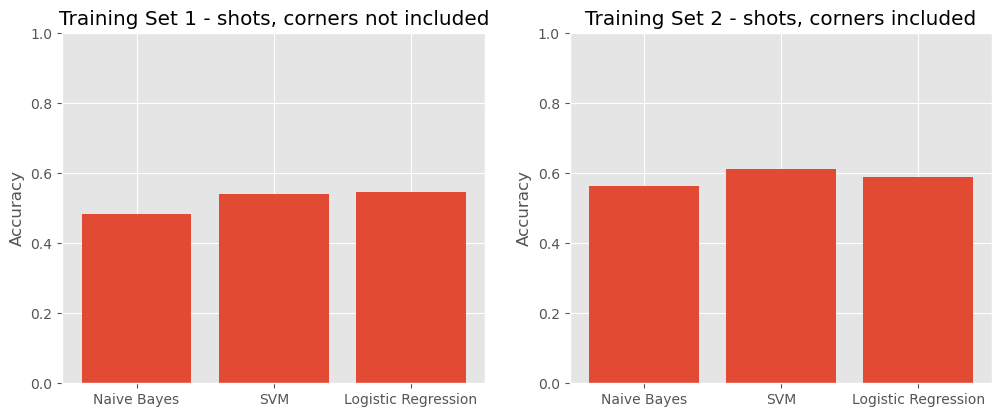

In [387]:
fig = plt.figure(figsize=(12, 10))

# Plot for the first set of mean scores
ax = fig.add_subplot(2, 2, 1)
ax.bar(range(0, 3), mean_scores, align='center')
ax.set_xticks(range(3))  # Set ticks to match the number of classifiers
ax.set_ylim(0, 1)
ax.set_ylabel("Accuracy")
ax.set_title("Training Set 1 - shots, corners not included")
ax.set_xticklabels(labels)

# Plot for the second set of mean scores
ax2 = fig.add_subplot(2, 2, 2)
ax2.bar(range(0, 3), mean_scores_2, align='center')
ax2.set_xticks(range(3))  # Set ticks to match the number of classifiers
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.set_title("Training Set 2 - shots, corners included")
ax2.set_xticklabels(labels)

plt.show()



We normalize the features to check if it improves result

In [389]:
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_train_2 = normalize(X_train_2)
pd.set_option('display.expand_frame_repr', False)

display(X_train)

array([[0.50276935, 0.44662577, 0.49363901, 0.55142445],
       [0.64855449, 0.42727439, 0.44863811, 0.44219624],
       [0.2487202 , 0.59223482, 0.66948284, 0.3730803 ],
       ...,
       [0.51282334, 0.48598899, 0.54316417, 0.45365142],
       [0.48878295, 0.57724216, 0.47228904, 0.45257681],
       [0.50619946, 0.37867187, 0.71000976, 0.31025128]])

In [390]:
display(X_train_2)

array([[0.06219363, 0.05524855, 0.06106419, ..., 0.23553329, 0.35329994,
        0.35329994],
       [0.09920889, 0.06535984, 0.06862783, ..., 0.3308842 , 0.46323787,
        0.46323787],
       [0.03619491, 0.08618473, 0.09742622, ..., 0.68292033, 0.60704029,
        0.30352015],
       ...,
       [0.11946679, 0.11321549, 0.12653495, ..., 0.13485962, 0.67429811,
        0.13485962],
       [0.07472894, 0.08825327, 0.07220722, ..., 0.4061656 , 0.56863184,
        0.4061656 ],
       [0.10873616, 0.0813421 , 0.15251643, ..., 0.61769155, 0.30884577,
        0.61769155]])

In [395]:
import numpy as np

nbb_scores = []
nbb_scores_2 = []

for i in np.logspace(-2, 3, 20):  # This will give values from 0.01 to 1000 on a logarithmic scale
    clf1 = MultinomialNB(alpha=i)
    clf1.fit(X_train, y_train)
    clf1.fit(X_train_2, y_train)
    scores = cross_val_score(clf1, X_train, y_train, cv=10)
    scores_2 = cross_val_score(clf1, X_train_2, y_train, cv=10)
    print("NB alpha ", i, " ", scores.mean(), " : ", scores_2.mean())
    
    nbb_scores.append(scores.mean())  
    nbb_scores_2.append(scores_2.mean())

   

NB alpha  0.01   0.48421052631578937  :  0.48421052631578937
NB alpha  0.018329807108324356   0.48421052631578937  :  0.48421052631578937
NB alpha  0.03359818286283781   0.48421052631578937  :  0.48421052631578937
NB alpha  0.06158482110660264   0.48421052631578937  :  0.48421052631578937
NB alpha  0.11288378916846889   0.48421052631578937  :  0.48421052631578937
NB alpha  0.20691380811147891   0.48421052631578937  :  0.48421052631578937
NB alpha  0.37926901907322497   0.48421052631578937  :  0.48421052631578937
NB alpha  0.6951927961775606   0.48421052631578937  :  0.48421052631578937
NB alpha  1.2742749857031335   0.48421052631578937  :  0.48421052631578937
NB alpha  2.3357214690901213   0.48421052631578937  :  0.48421052631578937
NB alpha  4.281332398719392   0.48421052631578937  :  0.48421052631578937
NB alpha  7.847599703514607   0.48421052631578937  :  0.48421052631578937
NB alpha  14.38449888287663   0.48421052631578937  :  0.48421052631578937
NB alpha  26.366508987303583   0.48

In [397]:
#With Normalization
clf = [MultinomialNB(alpha=10), SVC(kernel = 'linear', C=1.5, probability=True), LogisticRegression()]

labels = [ 'Naive Bayes', 'SVM', 'Log regres']

mean_scores = []
mean_scores_2 = []
cms = []

for i in range(0,3):

    clf[i].fit(X_train,y_train)
    clf[i].fit(X_train_2,y_train)

    scores = cross_val_score(clf[i], X_train, y_train, cv=10)
    scores_2 = cross_val_score(clf[i], X_train_2, y_train, cv=10)
    print (labels[i]," : ", scores.mean(), " : ", scores_2.mean())
    
    mean_scores.append(scores.mean())  
    mean_scores_2.append(scores_2.mean())
    


Naive Bayes  :  0.48421052631578937  :  0.48421052631578937
SVM  :  0.5560855263157894  :  0.5944078947368421
Log regres  :  0.5644736842105262  :  0.6006578947368422


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

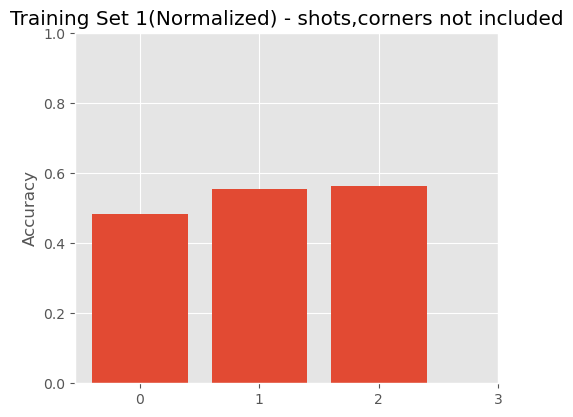

In [398]:
fig = plt.figure(figsize = (12,10))

ax = fig.add_subplot(2,2,1)

ax.bar(range(0,3),mean_scores,align='center');
ax.set_xticks(range(4));
ax.set_xticks(range(4));
ax.set_ylim(0,1);
ax.set_ylabel("Accuracy")
ax.set_title("Training Set 1(Normalized) - shots,corners not included")
ax.set_xticklabels(labels);

ax2 = fig.add_subplot(2,2,2);
ax2.bar(range(0,3),mean_scores_2,align='center');
ax2.set_xticks(range(4))
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0,1);
ax2.set_title("Training Set 2(Normalized) - shots,corners included")
ax2.set_xticklabels(labels);


We can see the performance of Naive Bayes and SVM reduces after normalization whereas the performance of Logistics Regression increases after normalization


### Conclusion

!["Prediction"](files/Prediction.png "Prediction")

It can be seen that when we include corners and shots in the feature we get a better output than without them. Support Vector Machine gives the best accuracy score without normalization.But after normalization there was an improvement in the Logistic Regression output. The betting accuracy of bookies was around 53% while the model created using SVM gave an accuracy of 61.29%. The accuracy can further increase if we could add more features like team form or player form. We could also add the twitter analysis for prediction. We could implement different model like xgboost with the same features which could improve the accuracy.

### References

[1] http://www.english-online.at/sports/soccer/european-football.htm

[2] http://www.bbc.com/sport/football/24354124

[3] https://www.kaggle.com/hugomathien/soccer

[4] https://www.pinnacle.com/en/betting-articles/Soccer/Mark-Lawrenson-vs-Pinnacle-Sports/VGJ296E4BSYNURUB

[5] http://scikit-learn.org/stable/modules/svm.html

[6] http://www.statisticssolutions.com/what-is-logistic-regression/

[7] http://scikit-learn.org/stable/modules/naive_bayes.html

[8] https://github.com/llSourcell/Predicting_Winning_Teams/blob/master/Prediction.ipynb

[9] https://www.kaggle.com/yonilev/the-most-predictable-league

[10] https://arxiv.org/ftp/arxiv/papers/1411/1411.1243.pdf

[11] https://github.com/llSourcell/Predicting_Winning_Teams/blob/master/Prediction.ipynb